# <font color='#eb3483'>K-Means</font>

K-Means is an unsupervised learning technique that puts datapoints that are quite similar into one group and those datapoints that are quite different are put in different groups. In this module we're going to learn how K-Means does this.

In [56]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(6,6)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

## <font color='#eb3483'>We load the data</font>

We will use the EPA vehicles dataset. 

To simplify things, we will use a smaller dataset, with less columns, and with the null values removed.

In [57]:
vehicles = pd.read_pickle("data/vehicles.3.grouped.pkl")

In [58]:
vehicles.head()

,co2,cylinders,displacement,year,vehicle_class_type,drive_type,transmission_type,fuel_type,displacement_type,consumption_type,co2_type,consumption_liters_mile
0,423.190476,4.0,2.0,1985,Small Cars,two,Manual,Normal,very small,low,low,0.180258
1,807.909091,12.0,4.9,1985,Small Cars,two,Manual,Normal,very big,very high,very high,0.344128
2,329.148148,4.0,2.2,1985,Small Cars,two,Manual,Normal,small,very low,very low,0.140200
3,807.909091,8.0,5.2,1985,Vans,two,Automatic,Normal,very big,very high,very high,0.344128
4,467.736842,4.0,2.2,1993,Small Cars,four,Manual,Premium,small,moderate,moderate,0.199232


In [59]:
vehicles.shape

(38194, 12)

In [60]:
vehicles.dtypes

co2                         float64
cylinders                   float64
displacement                float64
year                          int64
vehicle_class_type         category
drive_type                 category
transmission_type          category
fuel_type                  category
displacement_type          category
consumption_type           category
co2_type                   category
consumption_liters_mile     float64
dtype: object

## <font color='#eb3483'>Deal with missing values</font>


Check for missing values. Remove them.

In [61]:
vehicles.isna().sum()

co2                           0
cylinders                     3
displacement                  2
year                          0
vehicle_class_type         5655
drive_type                    0
transmission_type             0
fuel_type                     0
displacement_type             2
consumption_type              0
co2_type                      0
consumption_liters_mile       0
dtype: int64

<AxesSubplot:>

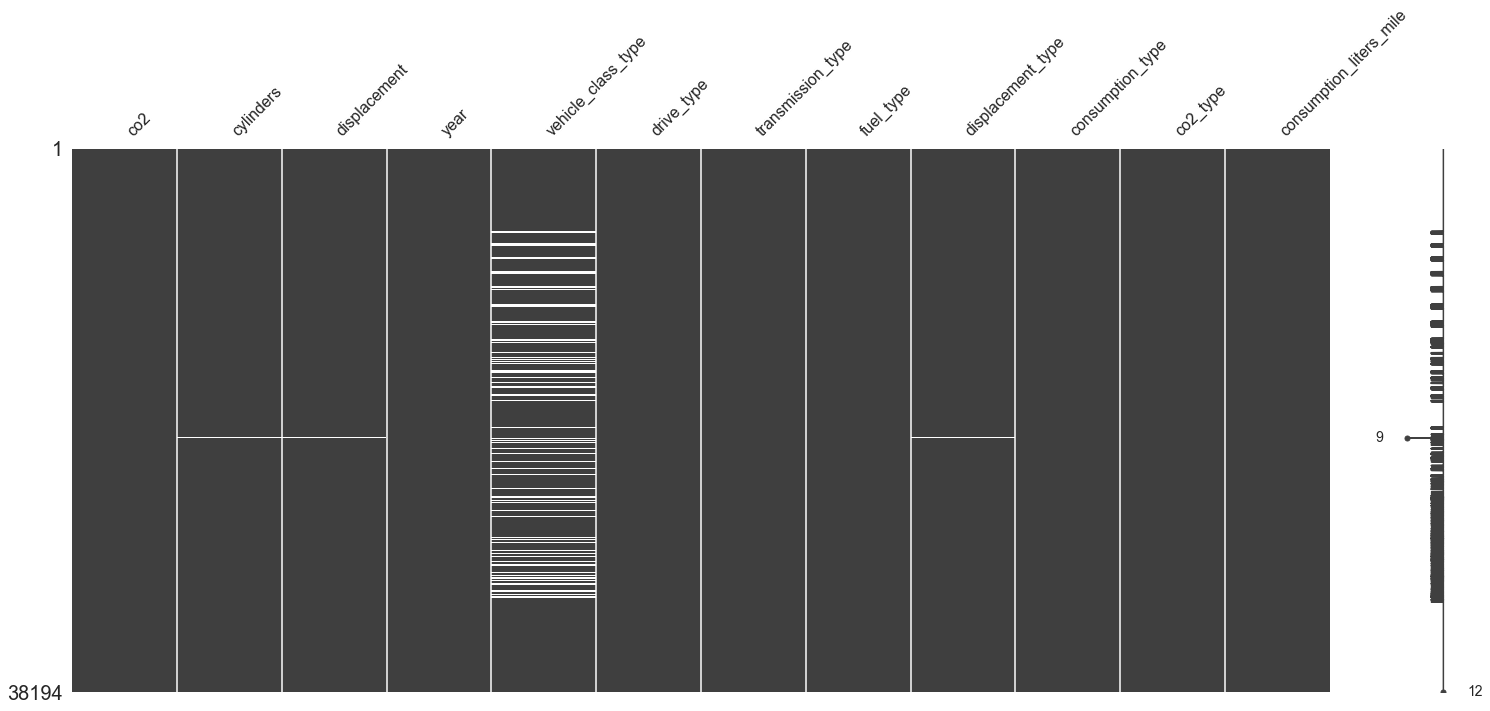

In [62]:
# A fun way to visualise missing values is from the missingno library.
  
# Importing the library (you may need to install it first pip install missingno)
import missingno as msno 
  
# Visualize missing values as a matrix 
msno.matrix(vehicles) 

In [63]:
# handle missing values
vehicles.dropna(inplace=True)

In [64]:
vehicles.shape

(32536, 12)

In [65]:
vehicles.head()

,co2,cylinders,displacement,year,vehicle_class_type,drive_type,transmission_type,fuel_type,displacement_type,consumption_type,co2_type,consumption_liters_mile
0,423.190476,4.0,2.0,1985,Small Cars,two,Manual,Normal,very small,low,low,0.180258
1,807.909091,12.0,4.9,1985,Small Cars,two,Manual,Normal,very big,very high,very high,0.344128
2,329.148148,4.0,2.2,1985,Small Cars,two,Manual,Normal,small,very low,very low,0.140200
3,807.909091,8.0,5.2,1985,Vans,two,Automatic,Normal,very big,very high,very high,0.344128
4,467.736842,4.0,2.2,1993,Small Cars,four,Manual,Premium,small,moderate,moderate,0.199232


## <font color='#eb3483'>Preprocess the data</font>


To use the data set we have to take cre of the categorical data. So let's split out the numerical variables, and the categorical variables into two separate data frames.

In [66]:
#splitting numerical and categorical data into two different data frames to make sure it is in a form we can use it
numerical_data = vehicles.select_dtypes(np.number)
categorical_data = vehicles.select_dtypes([object, "category"])


In [67]:
categorical_data.head()
#its good practice to double check that your code actually did what you intended it to do

,vehicle_class_type,drive_type,transmission_type,fuel_type,displacement_type,consumption_type,co2_type
0,Small Cars,two,Manual,Normal,very small,low,low
1,Small Cars,two,Manual,Normal,very big,very high,very high
2,Small Cars,two,Manual,Normal,small,very low,very low
3,Vans,two,Automatic,Normal,very big,very high,very high
4,Small Cars,four,Manual,Premium,small,moderate,moderate


In [68]:
numerical_data.head()


,co2,cylinders,displacement,year,consumption_liters_mile
0,423.190476,4.0,2.0,1985,0.180258
1,807.909091,12.0,4.9,1985,0.344128
2,329.148148,4.0,2.2,1985,0.140200
3,807.909091,8.0,5.2,1985,0.344128
4,467.736842,4.0,2.2,1993,0.199232


### <font color='#eb3483'>Normalise (fix scales) numerical data </font>

An important aspect when using K-means is that the distances are related to the variable scales. So we have to normalize the data before using this algorithm for clustering. We can use scikit-learn `MinMaxScaler()` for scaling a numerical variable to a range ([0,1] by default)

In [69]:
from sklearn.preprocessing import MinMaxScaler

numerical_data_normalized = MinMaxScaler().fit_transform(numerical_data) # this line scales our data

numerical_data_normalized = pd.DataFrame(              #this pops it back in data frame format 
                    numerical_data_normalized,
                    columns=numerical_data.columns) 

numerical_data_normalized.head()

,co2,cylinders,displacement,year,consumption_liters_mile
0,0.317749,0.142857,0.179487,0.028571,0.241830
1,0.627863,0.714286,0.551282,0.028571,0.586453
2,0.241943,0.142857,0.205128,0.028571,0.157589
3,0.627863,0.428571,0.589744,0.028571,0.586453
4,0.353657,0.142857,0.205128,0.257143,0.281734


### <font color='#eb3483'>One Hot encode our categorical data </font>


For categorical data, we will do simple one hot encoding via pandas `get_dummies()`

In [70]:
categorical_data_codified = pd.get_dummies(
                                    categorical_data, 
                                    drop_first=True,
                                    dtype="int64"
).reset_index() #have to reset the index to be able to concat

In [71]:
categorical_data_codified.head()

,index,vehicle_class_type_Medium Cars,vehicle_class_type_Small Cars,vehicle_class_type_Special Vehicles,vehicle_class_type_Station Wagons,vehicle_class_type_Trucks,vehicle_class_type_Vans,drive_type_two,transmission_type_Manual,fuel_type_Normal,...,displacement_type_big,displacement_type_very big,consumption_type_low,consumption_type_moderate,consumption_type_high,consumption_type_very high,co2_type_low,co2_type_moderate,co2_type_high,co2_type_very high
0,0,0,1,0,0,0,0,1,1,1,...,0,0,1,0,0,0,1,0,0,0
1,1,0,1,0,0,0,0,1,1,1,...,0,1,0,0,0,1,0,0,0,1
2,2,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
4,4,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [72]:
categorical_data_codified.shape

(32536, 24)

In [73]:
categorical_data_codified.dtypes # check that these are now all numerical

index                                  int64
vehicle_class_type_Medium Cars         int64
vehicle_class_type_Small Cars          int64
vehicle_class_type_Special Vehicles    int64
vehicle_class_type_Station Wagons      int64
vehicle_class_type_Trucks              int64
vehicle_class_type_Vans                int64
drive_type_two                         int64
transmission_type_Manual               int64
fuel_type_Normal                       int64
fuel_type_Other types of fuel          int64
fuel_type_Premium                      int64
displacement_type_small                int64
displacement_type_medium               int64
displacement_type_big                  int64
displacement_type_very big             int64
consumption_type_low                   int64
consumption_type_moderate              int64
consumption_type_high                  int64
consumption_type_very high             int64
co2_type_low                           int64
co2_type_moderate                      int64
co2_type_h

In [74]:
numerical_data_normalized.shape

(32536, 5)

In [75]:
numerical_data_normalized.dtypes

co2                        float64
cylinders                  float64
displacement               float64
year                       float64
consumption_liters_mile    float64
dtype: object

Now we join the numerical and categorical data back together to get our final data frame to use


In [76]:
vehicles_processed = pd.concat([
                            numerical_data_normalized,
                            categorical_data_codified
                        ], axis=1
)

In [77]:
vehicles_processed.shape

(32536, 29)

In [78]:
vehicles_processed.head()

,co2,cylinders,displacement,year,consumption_liters_mile,index,vehicle_class_type_Medium Cars,vehicle_class_type_Small Cars,vehicle_class_type_Special Vehicles,vehicle_class_type_Station Wagons,...,displacement_type_big,displacement_type_very big,consumption_type_low,consumption_type_moderate,consumption_type_high,consumption_type_very high,co2_type_low,co2_type_moderate,co2_type_high,co2_type_very high
0,0.317749,0.142857,0.179487,0.028571,0.241830,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0.627863,0.714286,0.551282,0.028571,0.586453,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
2,0.241943,0.142857,0.205128,0.028571,0.157589,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.627863,0.428571,0.589744,0.028571,0.586453,3,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,0.353657,0.142857,0.205128,0.257143,0.281734,4,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0


In [79]:
vehicles_processed = vehicles_processed.drop(columns = "index")

# <font color='#eb3483'>K-Means</font>

Scikit-learn implements KMeans in the module [sklearn.cluster.KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [80]:
from sklearn.cluster import KMeans

The most important hyperparameters for Kmeans are:

- **n_clusters**: The number of clusters (K), default is 8.
- **init**: Initialization method. A problem that K-Means has is that the solution it reachs depends on the random initialization of the cluster centers. `sklearn` uses a method `kmeans++` that is a more estable initialization method than random initialization.
- **n_init**: Number of initializations. `KMEans` runs the algorithm `n_init` times and selects the clusters with the minimum inertia.
- **max_iter**: Maximum number of iterations to stop.
- **tol**: Tolerance to stop (the bigger the tolerance, the sooner the algorithm will stop but might not find the best solution).

In [81]:
estimator_kmeans = KMeans(random_state=42, n_clusters=8) # instantiate our Kmeans model

estimator_kmeans.fit(vehicles_processed) # fit the model to our vehicles data

KMeans(random_state=42)

Since KMeans is unsupervised training we cant test against Known labels. Instead Kmeans split the data points into one of 8 clusters (we specified 8 clusters above) and outputs what the predicted cluster would be. 

Kmeans has the method `predict` like any other sklearn estimator that allows us to assign new observations to clusters.

In [82]:
estimator_kmeans.predict(vehicles_processed)

array([1, 3, 5, ..., 1, 1, 4])

We can get the coordinates of the cluster centroids with `cluster_centers_`

Don't worry too much about this. But incase you want to know. Each cluster has a centroid right. If we only had two feature variables (it would be easy to imagine this as the X & Y) and plot it out this way using a scatter plot in sns and coloring the scatter by the cluster it was assigned to.

In this isntance we had 29 input features - so it is giving us the X & Y & Z & .... which is impossible for us to even imagine plotting. But there are ways we could compare all the values per cluster to see which groups are most similar to each other without having to actually visualise this.


In [83]:
centroids = estimator_kmeans.cluster_centers_
centroids

array([[ 3.96095991e-01,  2.94274108e-01,  4.09862912e-01,
         3.31714866e-01,  3.27733941e-01,  6.16113744e-02,
         1.03588355e-01,  1.76935229e-01,  4.19769804e-02,
         4.30828255e-01,  1.24802528e-01,  6.91943128e-01,
         3.18438276e-01,  9.38388626e-01,  5.95802302e-02,
         2.03114421e-03,  1.00654480e-01,  2.99706613e-01,
         4.07582938e-01,  1.77612277e-01, -1.22124533e-15,
         4.16158881e-01,  5.82938389e-01,  9.02730761e-04,
        -2.77555756e-17, -4.66293670e-15,  9.97066125e-01,
         2.93387497e-03],
       [ 3.04096806e-01,  1.79143665e-01,  2.36490732e-01,
         3.85458462e-01,  2.25705702e-01,  1.88972667e-01,
         4.23892554e-01,  7.49293120e-02,  1.27474081e-01,
         1.11687088e-01,  1.41376060e-02,  8.62393968e-01,
         3.72761546e-01,  9.59472196e-01,  4.05278040e-02,
        -4.10782519e-15,  4.48162111e-01,  1.58576814e-01,
         7.39868049e-02,  4.47690858e-03,  9.76201697e-01,
        -1.11022302e-15,  1.69

In [84]:
centroids.shape

(8, 28)

We can see the final inertia for the clusters.

Inertia is the sum of squared error for each cluster.   
Therefore the smaller the inertia the denser the cluster(closer together all the points are)   

So we could try different Ks and see if we can get this inertia to decrease (without overfitting of course and while still gaining info) ... but wait for this a bit later on in the note book :)

In [85]:
estimator_kmeans.inertia_

62431.81176956934

### <font color='#eb3483'>Describing the clusters</font>

We now make a  function to help describe the clusters. This is useful if we want to present some summary to our client to describe the clusters

We assign the cluster label to a new column

In [86]:
#one cluster: high bias
#k clusters = k num of points: low bias
estimator_kmeans.labels_.shape # these are the predicted cluster labels

(32536,)

In [87]:
vehicles.shape # this is our original data frame

(32536, 12)

In [88]:
# we can just add the newly predicted cluster column onto our original dataframe.
vehicles["cluster_id"] = estimator_kmeans.labels_ 

In [89]:
vehicles.head()

,co2,cylinders,displacement,year,vehicle_class_type,drive_type,transmission_type,fuel_type,displacement_type,consumption_type,co2_type,consumption_liters_mile,cluster_id
0,423.190476,4.0,2.0,1985,Small Cars,two,Manual,Normal,very small,low,low,0.180258,1
1,807.909091,12.0,4.9,1985,Small Cars,two,Manual,Normal,very big,very high,very high,0.344128,3
2,329.148148,4.0,2.2,1985,Small Cars,two,Manual,Normal,small,very low,very low,0.140200,5
3,807.909091,8.0,5.2,1985,Vans,two,Automatic,Normal,very big,very high,very high,0.344128,3
4,467.736842,4.0,2.2,1993,Small Cars,four,Manual,Premium,small,moderate,moderate,0.199232,6


In [90]:
# we can see how many of each cluster we had in our original data frame
vehicles.cluster_id.value_counts()

5    5857
3    5804
0    4431
1    4244
4    3773
2    3227
6    2829
7    2371
Name: cluster_id, dtype: int64

We can create a function to try and summarize the clusters  
For the numerical values this is easy we can just ge the average value for that cluster.   
For the categorical values - this is where mode comes in really handy 

In [91]:
def cluster_summary(cluster_id):  # define a function and call it cluster_summary, that takes the input of a cluster id/label
    cluster = vehicles[vehicles.cluster_id==cluster_id] # pull out all the rows with that ID
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0] # get mode for categoricals
    cluster_summary.update(cluster.mean().to_dict()) # get means for numerical (only does for numerical if we didnt specify)
    return cluster_summary # display the summary 

In [92]:
# use our new function to get the summary of group 5
cluster_summary(5)

{'vehicle_class_type': 'Small Cars',
 'drive_type': 'two',
 'transmission_type': 'Manual',
 'fuel_type': 'Normal',
 'displacement_type': 'very small',
 'consumption_type': 'very low',
 'co2_type': 'very low',
 'co2': 323.93615128424,
 'cylinders': 4.007170906607478,
 'displacement': 1.8759433156906278,
 'year': 2000.9738774116443,
 'consumption_liters_mile': 0.13792244296248407,
 'cluster_id': 5.0}

In [93]:
cluster_summary(1)

{'vehicle_class_type': 'Small Cars',
 'drive_type': 'two',
 'transmission_type': 'Automatic',
 'fuel_type': 'Normal',
 'displacement_type': 'small',
 'consumption_type': 'low',
 'co2_type': 'low',
 'co2': 406.25380880049875,
 'cylinders': 4.508011310084826,
 'displacement': 2.4446277097078086,
 'year': 1997.4910461828463,
 'consumption_liters_mile': 0.17259036888009835,
 'cluster_id': 1.0}

In [94]:
# we can make a function that puts comparisons side by side so its easier for us to see in a data frame 

def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id))
    return pd.DataFrame(summaries).set_index("cluster_id").T

We now can compare clusters

In [95]:
cluster_comparison(0,1,2,3)

cluster_id,0.0,1.0,2.0,3.0
vehicle_class_type,Trucks,Small Cars,Small Cars,Trucks
drive_type,two,two,two,two
transmission_type,Automatic,Automatic,Automatic,Automatic
fuel_type,Normal,Normal,Normal,Normal
displacement_type,big,small,medium,very big
consumption_type,high,low,moderate,very high
co2_type,high,low,moderate,very high
co2,520.38537,406.253809,455.368051,664.44438
cylinders,6.119838,4.508011,5.32321,7.946072
displacement,3.796931,2.444628,2.968764,5.156943


In [96]:
cluster_comparison(0,1,2,3,4,5,6,7)

cluster_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
vehicle_class_type,Trucks,Small Cars,Small Cars,Trucks,Small Cars,Small Cars,Small Cars,Small Cars
drive_type,two,two,two,two,two,two,two,two
transmission_type,Automatic,Automatic,Automatic,Automatic,Automatic,Manual,Automatic,Automatic
fuel_type,Normal,Normal,Normal,Normal,Premium,Normal,Premium,Premium
displacement_type,big,small,medium,very big,very small,very small,medium,medium
consumption_type,high,low,moderate,very high,very low,very low,moderate,low
co2_type,high,low,moderate,very high,high,very low,moderate,low
co2,520.38537,406.253809,455.368051,664.44438,453.300901,323.936151,457.236086,406.044841
cylinders,6.119838,4.508011,5.32321,7.946072,6.058574,4.007171,6.100742,5.311261
displacement,3.796931,2.444628,2.968764,5.156943,3.314021,1.875943,3.393107,2.776761


### <font color='#eb3483'>Clustering in Exploratory Data Analysis</font>

We include cluster EDA to find natural groups in the dataset. 

Just like we can do `fit` and `transform` together with `fit_transform`, we can do `fit` and `predict` together with `fit_predict`.

<!--A part of Exploratory Data Analysis that we did not mention during the EDA class is to include a cluster analysis to find natural groups in the dataset (its part of the [original framework](https://www.districtdatalabs.com/data-exploration-with-python-2/) I based the one I use from)-->

In [97]:
def kmeans_cluster(df, n_clusters=2):
    """This function assigns clusters to every row in the dataframe via kmeans"""
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

def graph_summary_clustering(results):
    """this function produces a summary of the clusters"""
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count", "index"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

In [98]:
# this means if I want to try out 4 clusters instead of 8 its really easy for me to do
#Im going to choose 4 here instead of 8 

cluster_results = kmeans_cluster(vehicles_processed, 8)
cluster_summary = graph_summary_clustering(cluster_results);

KeyError: "['index'] not found in axis"

We get a summary, in which for numerical variables we get an idea of which clusters have higher values (remember, the variables are min max scaled), and for categorical variables, since they are one hot encoded, we get the percentage of each cluster that belongs to each one of the different values per categorical column (for example, if the column "consumption_type_high" for Cluster 1 is 0.2, that means that 20% of the cars in that cluster have consumption type=High).

In [99]:
cluster_summary

<function __main__.cluster_summary(cluster_id)>

We can put the summary in a heatmap

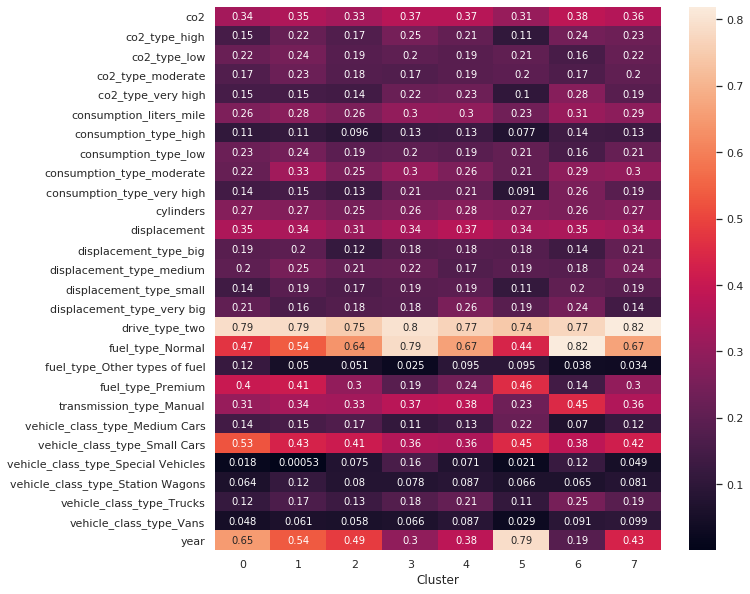

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cluster_summary.transpose(), annot=True);
#look at features with high variance, like fuel_type_normal, year

# <font color='#eb3483'> How do we choose K (number of clusters)?</font>

There are different options to choose K.

**1. Domain Knowledge**
Sometimes we already have knowledge of what the number of clusters should be. For example, lets say we want to cluster movies, a reasonable number of clusters would be the number of movie categories on IMDB.

**2. Business Requirements**
Sometimes the number of clusters is not a decision we need to take, because is a business constraint. For example, if the marketing team wants to do 3 different marketing campaigns, we need to cluster our clients in 3 different clusters. If we are grouping the guests in a wedding and we have 10 tables, then K has to be 10.

**3. [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering))**
The Elbow Method uses as a metric the variance explained as a factor of the number of clusters. We try to find the number of clusters where adding a new cluster doesnt increase the explained variance enough. Basically we want to find the point where adding a new cluster (and more complexity) doesnt benefit the model anymore.

We can use the inertia as a proxy for the percentage variance explained. Check the bonus below if you want the "robust and fancy way" of doing the elbow method

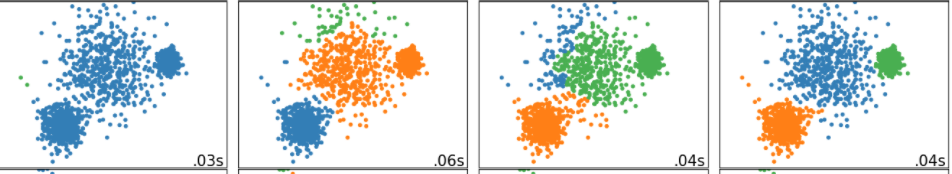


In [100]:
#Creating a function that takes in a range of values for K (or how many clusters)
# runs the model and then outputs the inertia value so we can see how well the clusters are grouped 


def evaluate_k_kmeans_inertia(k):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(vehicles_processed)
    return estimator_kmeans.inertia_

In [101]:
# %%time is a nifty "magic"in jupyter notebooks that times how long the code takes to run


In [106]:
%%time 
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=8
running Kmeans with k=10
running Kmeans with k=15
running Kmeans with k=20
running Kmeans with k=25
running Kmeans with k=30
Wall time: 55 s


In [107]:
results_k # so we get a 2d array back with the k + the intertia value

{2: 101368.01881608326,
 3: 89080.3974258723,
 4: 80250.50863159394,
 5: 73078.97665083384,
 8: 62431.81176956934,
 10: 57853.40949769056,
 15: 50468.52078300319,
 20: 44687.90488210425,
 25: 41442.278932384375,
 30: 37590.669747062806}

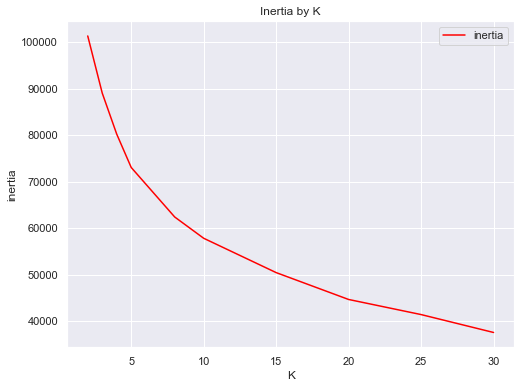

In [108]:
# we can now plot this to see where the inflection point is or where adding more clusters doesnt really add to gaining
# more information from extra clusters

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend()


For this dataset, we see K=15 is probably a good choice with the inertia criterion.  

But again - this has to be linked back to the problem. Is it logical for me to say have regulations for 15 different groups of cars - or would say 8 be good enough and much easier to work with for regulations.

### <font color='#eb3483'>Bonus: More Accurate way of using Elbow method with Within Cluster Sum of Squares</font>
The elbow method in reality works by calculating how much variance of the original data is explained relative to the number of clusters. It is much more time consuming to compute

In [50]:
from scipy.spatial.distance import cdist

In [51]:
print(cdist.__doc__)


    Compute distance between each pair of the two collections of inputs.

    See Notes for common calling conventions.

    Parameters
    ----------
    XA : ndarray
        An :math:`m_A` by :math:`n` array of :math:`m_A`
        original observations in an :math:`n`-dimensional space.
        Inputs are converted to float type.
    XB : ndarray
        An :math:`m_B` by :math:`n` array of :math:`m_B`
        original observations in an :math:`n`-dimensional space.
        Inputs are converted to float type.
    metric : str or callable, optional
        The distance metric to use.  If a string, the distance function can be
        'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
        'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon',
        'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto',
        'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean',
        'wminkowski', 'yule'.
    *args : tuple. 

We calculate the total variance by measuring the distances between each point and the average for each variable.

In [52]:
total_variance = cdist(
    XA=vehicles_processed, 
    XB=np.array([vehicles_processed.mean()])
)

In [53]:
total_variance_sum = total_variance.sum()

In [54]:
total_variance_sum

326053677.7827675

Now we create functions to calculate the **Within-Cluster sum of squares (WSS)** and the explained variance (defined as the reduction of variance compared to the total variance, which would be the variance where k=1).

The *WSS* (also called **Cohesion**) is defined as :

$$\sum\limits_{k=1}^K\sum\limits_{x\in C_k}\sum\limits_{j}^d {(x_{ij}-\mu_j)^2}$$

So basically:
```
    for each cluster k:
        for each point i in the cluster k:
            for each variable j:
                calculate the squared difference of the variable j for point i and the mean for variable j in cluster k
```

In [55]:
def cluster_variance(cluster_id, cluster_centroid, cluster_labels):
    cluster_elements = vehicles_processed[cluster_labels==cluster_id]
    return cdist(XA=cluster_elements, XB=np.array([cluster_centroid])).sum()

def variance_measure(estimator_kmeans, total_variance):
    clusters_labels = estimator_kmeans.labels_
    wss = 0
    for i, cluster_id in enumerate(np.unique(clusters_labels)):
        cluster_centroid = estimator_kmeans.cluster_centers_[i]
        wss += cluster_variance(cluster_id, cluster_centroid, clusters_labels)
    return (total_variance-wss) / total_variance

We create another evaluation function that returns the inertia.

In [56]:
def inertia_measure(estimator_kmeans):
    return estimator_kmeans.inertia_

Now we create a function that evaluates the intertia and percentage variance explained for a value of K.

In [57]:
def evaluate_k_kmeans(k, scoring, **kwargs):
    scoring_measure = None
    if scoring=="inertia":
        scoring_measure = inertia_measure
    elif scoring=="variance":
        scoring_measure = variance_measure
        
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(vehicles_processed)
    return scoring_measure(estimator_kmeans, **kwargs)

Now we evaluate the results for a range of K.

**Note: This step takes a long time!**

In [58]:
results_k = {}
range_k = [5, 10, 20, 30, 50, 100, 200]
for k in range_k:
    results_k[k] = (
        evaluate_k_kmeans(k, "inertia"), 
        evaluate_k_kmeans(k, "variance", total_variance=total_variance_sum), 
    )

In [59]:
results_k

{5: (152213782746.2596, 0.8142405477683634),
 10: (39211641253.27941, 0.9053072447947551),
 20: (9563671168.866833, 0.9529730164028811),
 30: (4118622523.1020737, 0.9694582191443332),
 50: (1483405124.4462395, 0.981724662257861),
 100: (355392915.0831337, 0.9910884055253363),
 200: (89446783.1709672, 0.9955333812567814)}

Now we plot the results to see where the "elbow" is.

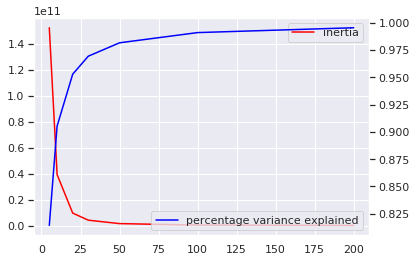

In [60]:
ax1 = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1][0] for c in results_k.items()], label="inertia", color="red"
)
with sns.axes_style("dark"):
    ax2 = ax1.twinx()
    
ax2 = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1][1] for c in results_k.items()], label="percentage variance explained", color="blue",
    ax=ax2)



<!--fig, ax1 = plt.subplots()

ax1.plot(
    [c[0] for c in results_k.items()],
    [c[1][0] for c in results_k.items()], label="inertia", color="red")
ax1.set_ylabel('inertia', color="red")


ax2 = ax1.twinx()
ax2.plot(
    [c[0] for c in results_k.items()],
    [c[1][1] for c in results_k.items()], label="percentage variance explained", color="blue")
ax2.set_ylabel('percentage variance', color='blue')

plt.xlabel("K")
plt.legend()
plt.title("Percentage variance / Inertia by. K");-->

For this dataset, we see K= 50 - 70ish is probably a sound choice - but would in reality might not be practical.

### <font color='#eb3483'>BONUS-MiniBatchKMeans</font>

`scikit-learn` has a different implementation named `MiniBatchKMeans`. This implementation process the dataset in batches instead of loading it all in memory. It works faster than `KMeans` at the cost of producing clusters with a higher inertia.

MiniBatchKMeans works the same way as KMeans, it just takes an additional hyperparameter `batch_size` that defines the number of elements to train on each batch.

In [61]:
from sklearn.cluster import MiniBatchKMeans

In [62]:
%%time
estimator_kmeans = KMeans(n_clusters=8).fit(vehicles_processed)

CPU times: user 4.1 s, sys: 72 ms, total: 4.17 s
Wall time: 1.07 s


In [64]:
estimator_kmeans.inertia_

62075787867.25824

In [65]:
%%time
estimator_kmeans_minibatch = MiniBatchKMeans(n_clusters=8).fit(vehicles_processed)

CPU times: user 721 ms, sys: 3.65 ms, total: 724 ms
Wall time: 182 ms


In [66]:
estimator_kmeans_minibatch.inertia_

66241745990.30588

We see that MiniBatchKMeans is faster but it's final inertia is higher.